In [2]:
import os
import sys
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils
from scipy.optimize import least_squares

BDC is using numpy


In [3]:
@nb.njit()
def get_common_rows(specnum0,specnum1,idxstart0,idxstart1):
    nrows0,nrows1=specnum0.shape[0],specnum1.shape[0]
    maxrows=min(nrows0,nrows1)
    rownums0=np.empty(maxrows,dtype='int64')
    rownums0[:]=-1
    rownums1=rownums0.copy()
    rowidx=rownums0.copy()
    i=0;j=0;row_count=0;
    while i<nrows0 and j<nrows1:
        if (specnum0[i]-idxstart0)==(specnum1[j]-idxstart1):
            rownums0[row_count]=i
            rownums1[row_count]=j
            rowidx[row_count]=specnum0[i]-idxstart0
            i+=1
            j+=1
            row_count+=1
        elif (specnum0[i]-idxstart0)>(specnum1[j]-idxstart1):
            j+=1
        else:
            i+=1
    return row_count,rownums0,rownums1,rowidx

@nb.njit(parallel=True)
def avg_xcorr_4bit_2ant_float(pol0,pol1,specnum0,specnum1,idxstart0,idxstart1,delay=None,freqs=None):
    row_count,rownums0,rownums1,rowidx=get_common_rows(specnum0,specnum1,idxstart0,idxstart1)
    ncols=pol0.shape[1]
#     print("ncols",ncols)
    assert pol0.shape[1]==pol1.shape[1]
    xcorr=np.zeros((row_count,ncols),dtype='complex64') # in the dev_gen_phases branch
    if delay is not None:
        for i in nb.prange(row_count):
            for j in range(ncols):
                xcorr[i,j] = pol0[rownums0[i],j]*np.conj(pol1[rownums1[i],j]*np.exp(2j*np.pi*delay[rowidx[i]]*freqs[j]))
    else:
        for i in nb.prange(row_count):
            xcorr[i,:] = pol0[rownums0[i],:]*np.conj(pol1[rownums1[i],:])
    return xcorr

def get_coarse_xcorr(f1, f2, Npfb=4096):
    if len(f1.shape) == 1:
        f1 = f1.reshape(-1, 1)
    if len(f2.shape) == 1:
        f2 = f2.reshape(-1, 1)
    chans = f1.shape[1]
    Nsmall = f1.shape[0]
    wt = np.zeros(2 * Nsmall)
    wt[:Nsmall] = 1
    n_avg = np.fft.irfft(np.fft.rfft(wt) * np.conj(np.fft.rfft(wt)))
#     print(n_avg)
#     n_avg[Nsmall] = np.nan
#     print(n_avg[Nsmall-10:Nsmall+10])
    n_avg = np.tile(n_avg, chans).reshape(chans, 2*Nsmall)
#     print(n_avg.shape)
    bigf1 = np.vstack([f1, np.zeros(f1.shape, dtype=f1.dtype)])
    bigf2 = np.vstack([f2, np.zeros(f2.shape, dtype=f2.dtype)])
    bigf1 = bigf1.T.copy()
    bigf2 = bigf2.T.copy()
    bigf1f = np.fft.fft(bigf1,axis=1)
    bigf2f = np.fft.fft(bigf2,axis=1)
    xx = bigf1f * np.conj(bigf2f)
    xcorr = np.fft.ifft(xx,axis=1)
    xcorr = xcorr / n_avg
    xcorr[:,Nsmall] = np.nan
    return xcorr

STANDARDIZED STARTING VARIABLES

In [7]:
T_SPECTRA = 4096/250e6

global_start_time = 1721800002
visibility_window = 1000

c_acclen = 10**6 
v_acclen = 30000

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((visibility_window)/C_T_ACCLEN)
v_nchunks = int((visibility_window)/V_T_ACCLEN)

a1_path = "/scratch/s/sievers/mohanagr/mars1_2024/baseband/"
a2_path = "/scratch/s/sievers/mohanagr/mars2_2024/baseband/"

dir_parents = []
dir_parents.append(a1_path)
dir_parents.append(a2_path)

a1_coords = [79+25.031/60, -90-46.041/60, 189]  # MARS 1
a2_coords = [79+25.033/60, -90-45.531/60, 176]  # MARS 2
tle_path = outils.get_tle_file(1721800002, "/project/s/sievers/mohanagr/OCOMM_TLES")

coords = []
coords.append(a1_coords)
coords.append(a2_coords)

SATELLITE INFORMATION

In [8]:
dt=5
niter = 3600 * 24 // dt  #because a file is one day I believe
alititude_cutoff = 15
rsats = outils.get_risen_sats(tle_path, a1_coords, global_start_time, dt=dt, niter = niter, altitude_cutoff=alititude_cutoff) #intervals of dt (=5s)

Starting Time of 1721800002 with a dt of 5


Text(0, 0.5, 'Sats Risen')

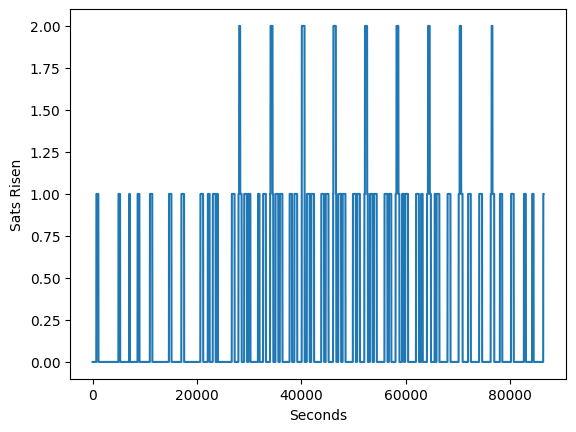

In [9]:
num_sats_risen = [len(x) for x in rsats]
plt.plot(np.arange(len(rsats))*dt,num_sats_risen)
plt.xlabel("Seconds")
plt.ylabel("Sats Risen")

(0.0, 20000.0)

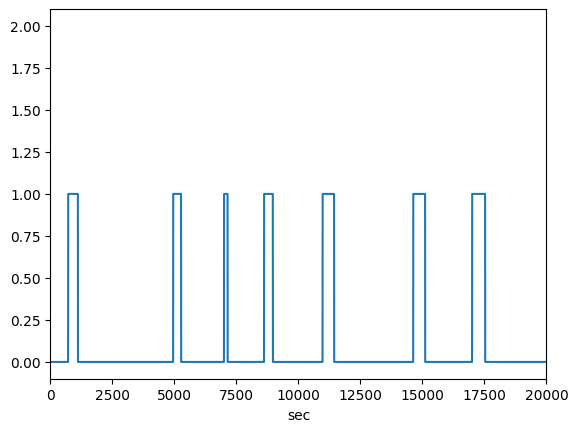

In [10]:
#zoomed in
num_sats_risen = [len(x) for x in rsats]
plt.plot(np.arange(len(rsats))*5,num_sats_risen)
plt.xlabel("sec")
plt.xlim(0,20000)

{44387, 59051, 57166, 28654, 33591, 25338}
[44387 59051 57166 28654 33591 25338]


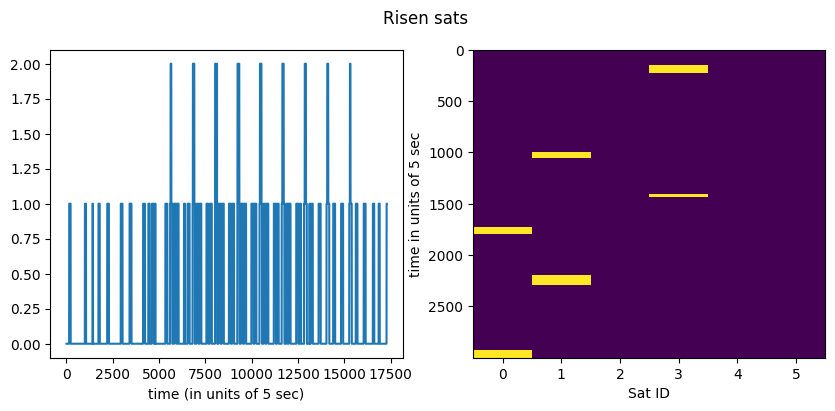

In [11]:
#satmap stuff

num_sats_risen = [len(x) for x in rsats]
satnums=[]
for s in rsats:
    if len(s)>0:
        for j in range(len(s)):
            satnums.append(s[j][0])

satids = set(satnums)
print(satids)
satlist = (np.array(list(satids)))
print(satlist)
satmap = {}
assert min(satlist) > len(
    satlist
)  # to make sure there are no collisions, we'll never have an i that's also a satnum
for i, satnum in enumerate(satlist):
    satmap[i] = satnum
    satmap[satnum] = i
arr = np.zeros((len(rsats), len(satlist)), dtype="int64")
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10,4)
fig.suptitle(f"Risen sats")
ax[0].plot(num_sats_risen)
ax[0].set_xlabel("time (in units of 5 sec)")
for i, row in enumerate(rsats):
    for satnum, satele,sataz in row:
        arr[i][satmap[satnum]] = 1
ax[1].set_ylabel("time in units of 5 sec")
ax[1].set_xlabel("Sat ID")
ax[1].imshow(arr[:3000],aspect='auto',interpolation="none")

[[[143, 222], [3]], [[990, 1054], [1]], [[1400, 1429], [3]], [[1723, 1794], [0]], [[2195, 2288], [1]], [[2926, 3022], [0]], [[3401, 3506], [1]], [[4130, 4236], [0]], [[4414, 4485], [5]], [[4605, 4714], [1]], [[4775, 4801], [2]], [[5333, 5441], [0]], [[5589, 5615], [4]], [[5615, 5655], [4, 5]], [[5655, 5711], [5]], [[5808, 5916], [1]], [[5971, 6048], [2]], [[6337, 6397], [3]], [[6533, 6641], [0]], [[6801, 6817], [4]], [[6817, 6896], [4, 5]], [[6896, 6923], [5]], [[7008, 7116], [1]], [[7175, 7274], [2]], [[7549, 7642], [3]], [[7732, 7840], [0]], [[8018, 8123], [4, 5]], [[8209, 8318], [1]], [[8379, 8486], [2]], [[8762, 8870], [3]], [[8932, 9040], [0]], [[9226, 9323], [4, 5]], [[9323, 9338], [4]], [[9415, 9522], [1]], [[9582, 9690], [2]], [[9974, 10087], [3]], [[10138, 10243], [0]], [[10413, 10436], [5]], [[10436, 10520], [4, 5]], [[10520, 10548], [4]], [[10629, 10727], [1]], [[10782, 10889], [2]], [[11185, 11297], [3]], [[11355, 11447], [0]], [[11610, 11644], [5]], [[11644, 11718], [4, 5]

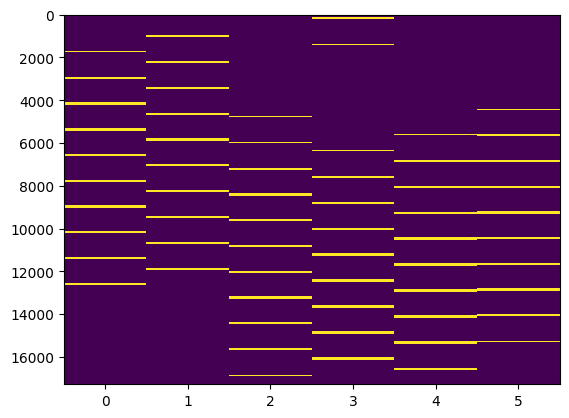

In [12]:
#get the pulses too
p = outils.get_simul_pulses(arr)
npulses = len(p)
print(p)

This is the mock satellite detection output

In [13]:
#pulses is now in seconds, with satID and with channel number of the pulse.

pulses = []
for i in range(len(p)):
    temp = []
    temp.append(np.array(p[i][0]) * 5)
    temp.append(int(satmap[p[i][1][0]]))
    pulses.append(temp)

print(pulses)

start_times = [ p[0][0] for p in pulses]
#print(start_times)
durations_secs = [p[0][1]- p[0][0] for p in pulses]
#print(durations_secs)
durations_chunks = [int((p[0][1]- p[0][0])/( T_SPECTRA * v_acclen )) for p in pulses]
#print(durations_chunks)
print("Number of Pulses:", npulses)


[[array([ 715, 1110]), 28654], [array([4950, 5270]), 59051], [array([7000, 7145]), 28654], [array([8615, 8970]), 44387], [array([10975, 11440]), 59051], [array([14630, 15110]), 44387], [array([17005, 17530]), 59051], [array([20650, 21180]), 44387], [array([22070, 22425]), 25338], [array([23025, 23570]), 59051], [array([23875, 24005]), 57166], [array([26665, 27205]), 44387], [array([27945, 28075]), 33591], [array([28075, 28275]), 33591], [array([28275, 28555]), 25338], [array([29040, 29580]), 59051], [array([29855, 30240]), 57166], [array([31685, 31985]), 28654], [array([32665, 33205]), 44387], [array([34005, 34085]), 33591], [array([34085, 34480]), 33591], [array([34480, 34615]), 25338], [array([35040, 35580]), 59051], [array([35875, 36370]), 57166], [array([37745, 38210]), 28654], [array([38660, 39200]), 44387], [array([40090, 40615]), 33591], [array([41045, 41590]), 59051], [array([41895, 42430]), 57166], [array([43810, 44350]), 28654], [array([44660, 45200]), 44387], [array([46130, 

Need a filtered pulses list (so that there are 5 good ones we can trust)

In [14]:
filtered_pulses = [[[715, 1110], [28654], [1836]], [[4950, 5270], [59051], [1836]], [[7000, 7145], [28654], [1836]], [[8615, 8970], [44387], [1836]], [[10975, 11440], [1]], [[14630, 15110], [0]]]

In [15]:
print(filtered_pulses[2][0][0])

7000


<h1 style="font-size:30pt">PREDICTED PHASES</h1>

In [18]:
def phase_predictor(fit_coords, pulse_idx):
    
    ref_coords = coords[0]

    relative_start_time = filtered_pulses[pulse_idx][0][0]
    pulse_duration_sec = filtered_pulses[pulse_idx][0][1] - filtered_pulses[pulse_idx][0][0]
    pulse_duration_chunks = int( pulse_duration_sec / (T_SPECTRA * v_acclen) )

    time_start = global_start_time + relative_start_time
    sat_ID = filtered_pulses[pulse_idx][1][0]

    pulse_channel_idx = filtered_pulses[pulse_idx][2][0]
    pulse_freq = outils.chan2freq(pulse_channel_idx, alias=True)

    # 'd' has one entry per second
    d = outils.get_sat_delay(ref_coords, fit_coords, tle_path, time_start, visibility_window+1, sat_ID)
    # 'delay' has one entry per chunk (~0.5s) 
    delay = np.interp(np.arange(0, v_nchunks) * v_acclen * T_SPECTRA, np.arange(0, int(visibility_window)+1), d)
    #thus 'pred' has one entry for each chunk
    pred = (-delay[:pulse_duration_chunks]+ delay[0]) *  2*np.pi * pulse_freq

    return pred



catalog #59051 epoch 2024-07-24 21:55:34 UTC


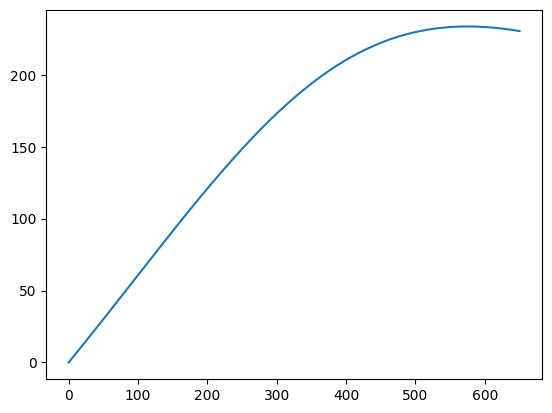

In [19]:
pred1 = phase_predictor(a2_coords, 1)
plt.plot(pred1)

In [20]:
pred1.shape

(651,)

In [21]:
pulse_idx = 1
idx_correction=109993-100000

<h1 style="font-size:30pt">OBSERVED PHASES</h1>

In [22]:
relative_start_time = filtered_pulses[pulse_idx][0][0]
t_start = global_start_time + relative_start_time
t_end = t_start + visibility_window

files_a1, idx1 = butils.get_init_info(t_start, t_end, a1_path)
files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)

print('initial offset:', idx1-idx2)

if idx_correction>0:
    idx1+=idx_correction
else:
    idx2+=np.abs(idx_correction)

print('final offset:', idx1-idx2)

channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
chanstart = np.where(channels == 1834)[0][0] 
chanend = np.where(channels == 1852)[0][0]
nchans=chanend-chanstart

ant1 = bdc.BasebandFileIterator(files_a1, 0, idx1, v_acclen, nchunks= v_nchunks, chanstart = chanstart, chanend = chanend, type='float')
ant2 = bdc.BasebandFileIterator(files_a2, 0, idx2, v_acclen, nchunks= v_nchunks, chanstart = chanstart, chanend = chanend, type='float')

initial offset: 976563
final offset: 986556
Not reading any data
ACCLEN RECEIVED IS 30000
took 0.229 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721804929.raw
START SPECNUM IS 1291903660 obj start at 1290489858
ACCLEN RECEIVED IS 30000
took 1.540 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721804945.raw
START SPECNUM IS 1348147319 obj start at 1347720073


In [23]:
m1=ant1.spec_num_start
m2=ant2.spec_num_start
visibility_phased = np.zeros((v_nchunks,len(ant1.channel_idxs)), dtype='complex64')
st=time.time()
print(f"--------- Processing Pulse Idx {pulse_idx} ---------")
for i, (chunk1,chunk2) in enumerate(zip(ant1,ant2)):
        xcorr = avg_xcorr_4bit_2ant_float(
            chunk1['pol0'], 
            chunk2['pol0'],
            chunk1['specnums'],
            chunk2['specnums'],
            m1+i*v_acclen,
            m2+i*v_acclen)
        visibility_phased[i,:] = np.sum(xcorr,axis=0)/v_acclen
        print("CHUNK", i, " has ", xcorr.shape[0], " rows")
print("Time taken final:", time.time()-st)
visibility_phased = np.ma.masked_invalid(visibility_phased)
vis_phase = np.angle(visibility_phased)

--------- Processing Pulse Idx 1 ---------
CHUNK 0  has  30000  rows
CHUNK 1  has  30000  rows
CHUNK 2  has  30000  rows
CHUNK 3  has  30000  rows
CHUNK 4  has  30000  rows
CHUNK 5  has  30000  rows
CHUNK 6  has  30000  rows
CHUNK 7  has  30000  rows
CHUNK 8  has  30000  rows
CHUNK 9  has  30000  rows
CHUNK 10  has  30000  rows
CHUNK 11  has  30000  rows
CHUNK 12  has  30000  rows
CHUNK 13  has  30000  rows
CHUNK 14  has  30000  rows
CHUNK 15  has  30000  rows
CHUNK 16  has  30000  rows
CHUNK 17  has  30000  rows
CHUNK 18  has  30000  rows
CHUNK 19  has  30000  rows
CHUNK 20  has  30000  rows
CHUNK 21  has  30000  rows
CHUNK 22  has  30000  rows
CHUNK 23  has  30000  rows
CHUNK 24  has  30000  rows
CHUNK 25  has  30000  rows
CHUNK 26  has  30000  rows
CHUNK 27  has  30000  rows
CHUNK 28  has  30000  rows
CHUNK 29  has  30000  rows
CHUNK 30  has  30000  rows
CHUNK 31  has  30000  rows
CHUNK 32  has  30000  rows
CHUNK 33  has  30000  rows
CHUNK 34  has  30000  rows
CHUNK 35  has  30000  

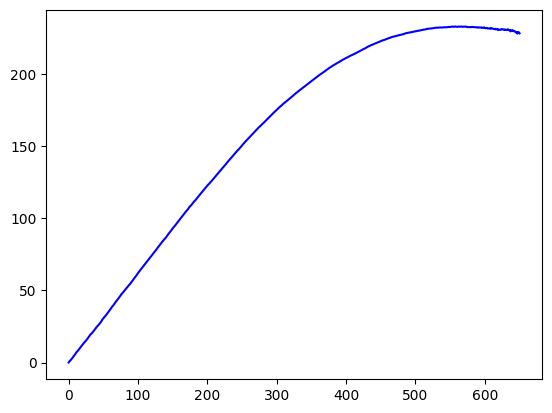

In [24]:
obs1 = np.unwrap(vis_phase[0:651,2])
plt.plot(obs1, color='blue')

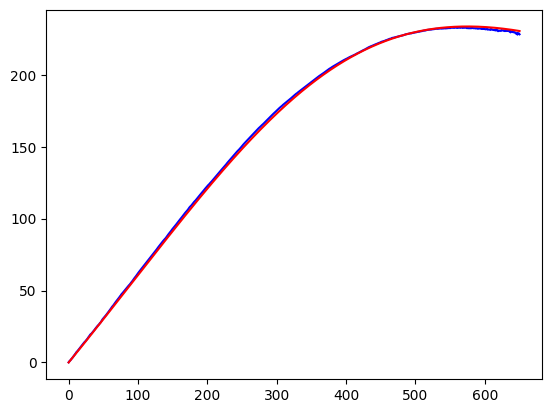

In [25]:
obs1 = np.unwrap(vis_phase[0:651,2])

plt.plot(obs1, color='blue')
plt.plot(pred1, color='red')

Make the data array

In [26]:
# Inputs and outputs with different lengths
data = [obs1]

In [27]:
# Initial guess for coordinates (e.g., [scale, offset])
initial_guess = a2_coords

In [30]:
#beware the pulse_idx + 1 that I have in here just for now to offset the single datapoint that I have in here

def get_residuals(coordinates):
    all_res = []
    for pulse_idx, observed_data in enumerate(data):
        predicted = phase_predictor(coordinates, pulse_idx + 1)
        res = predicted - observed_data
        all_res.append(res)
    return np.concatenate(all_res)  # Returns a single long 1D array

In [31]:
# Optimize
result = least_squares(get_residuals, initial_guess)

# Results
if result.success:
    print("Fitted coordinates:", result.x)
else:
    print("Optimization failed:", result.message)

catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #5